In [60]:
import pandas as pd
import sys 
import scipy 
import numpy as np
import sklearn
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from collections import Counter
from sklearn import metrics
import os
import string
from collections import defaultdict
from nltk import word_tokenize, sent_tokenize
import nltk
from   sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
data = pd.read_excel('final_project.xlsx', 'Marriott')
df = data.copy()
df.head()

df["rating"] = df["rating"].astype(int)
df["review"] = df["review"].astype(str)
df["is_bad_review"] = df["rating"].apply(lambda x:1 if x < 3 else 0)

#select only relevant columns
reviews_df = df[["member_level","review","is_bad_review","rating"]]

reviews_df.head(10)

,member_level,review,is_bad_review,rating
0,Member,This hotel is very dirty.,1,1
1,Member,The driveway/entrance is uninspiring. Checkin ...,0,3
2,Platinum,Not impressed Continue to undergo construction...,0,3
3,Member,Amazing every aspect ... the food is an issue ...,0,5
4,Member,"Very nice staff, beautiful hotel and view. Ver...",0,5
5,Member,Done. My stay at Marriott was good. I apprecia...,0,3
6,NaN,Requested shower caps but as room was not assi...,0,4
7,Gold,We stayed at the Atlanta Marriott Marquis duri...,0,5
8,Gold,Nice downtown location. Lovely hotel. Good ser...,0,3
9,Member,Enjoyed the staying at the Marriott. Most of t...,0,4


In [62]:
reviews_df.rating.mean()

4.217764540995095

# Cleaning and Preprocessing

In [63]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag 
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
def clean_text(text):
    text = text.lower()
    #tokenize text and remove punctuation 
    text = [word.strip(string.punctuation) for word in text.split(" ") ]
    #remove words that contain numbers 
    text = [word for word in text if not any(c.isdigit() for c in word)]
    #remove stop words 
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    #remove empty tokens 
    text = [t for t in text if len(t)>0]
    #pos tag text 
    pos_tags = pos_tag(text)
    #lemmatize text 
    text = [WordNetLemmatizer().lemmatize(t[0],get_wordnet_pos(t[1])) for t in pos_tags]
    #remove words with only one letter
    text = [t for t in text if len(t) > 1]
    #join all
    text = " ".join(text)
    return(text)

#clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
reviews_df.head()

,member_level,review,is_bad_review,rating,review_clean
0,Member,This hotel is very dirty.,1,1,hotel dirty
1,Member,The driveway/entrance is uninspiring. Checkin ...,0,3,driveway/entrance uninspiring checkin time lon...
2,Platinum,Not impressed Continue to undergo construction...,0,3,impressed continue undergo construction help
3,Member,Amazing every aspect ... the food is an issue ...,0,5,amaze every aspect food issue want try place g...
4,Member,"Very nice staff, beautiful hotel and view. Ver...",0,5,nice staff beautiful hotel view expensive vale...


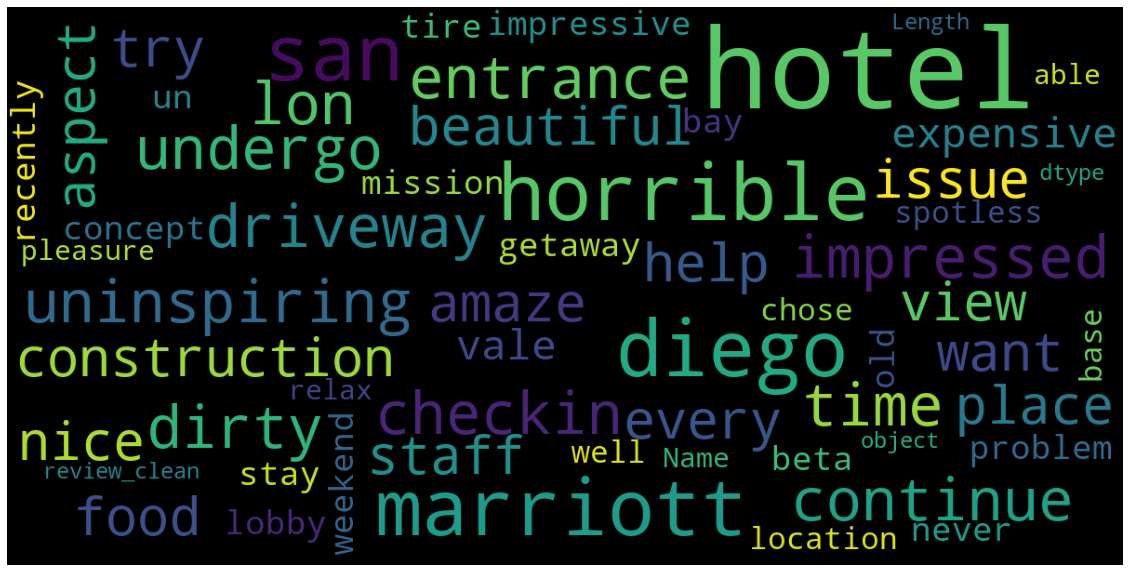

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 200,
        max_font_size = 40,
        scale = 3, 
        random_state = 42
    ).generate(str(data))
    
    fig = plt.figure(1,figsize = (20,20))
    plt.axis('off')
    if title:
        fig.subtitle(title,fontsize =20)
        fig.subplots_adjust(top =2.3)
        
    plt.imshow(wordcloud)
    plt.show()
    
#print wordcloud
show_wordcloud(reviews_df["review_clean"])

In [66]:
#add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

#add number of words column 
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [67]:
reviews_df.head()

,member_level,review,is_bad_review,rating,review_clean,nb_chars,nb_words
0,Member,This hotel is very dirty.,1,1,hotel dirty,25,5
1,Member,The driveway/entrance is uninspiring. Checkin ...,0,3,driveway/entrance uninspiring checkin time lon...,130,19
2,Platinum,Not impressed Continue to undergo construction...,0,3,impressed continue undergo construction help,65,10
3,Member,Amazing every aspect ... the food is an issue ...,0,5,amaze every aspect food issue want try place g...,154,31
4,Member,"Very nice staff, beautiful hotel and view. Ver...",0,5,nice staff beautiful hotel view expensive vale...,109,17


In [70]:
from scipy.stats import ttest_ind

result = ttest_ind(
   reviews_df[reviews_df["is_bad_review"]== 1]["nb_words"],
   reviews_df[reviews_df["is_bad_review"] == 0]["nb_words"],
)
print('t-statistic:', result[0])
print('p-value:    ', result[1])

print("Average length of bad reviews:")
print(reviews_df[reviews_df["is_bad_review"]== 1]["nb_words"].mean())
print("Average length of good reviews:")
print(reviews_df[reviews_df["is_bad_review"] == 0]["nb_words"].mean())

t-statistic: 20.112297208627133
p-value:     1.9433400873468887e-88
Average length of bad reviews:
56.310344827586206
Average length of good reviews:
32.94698100069631


# Vader for Review Distinction

In [9]:
#add sentiment analysis columns using Vader sentiment 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"]= reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'],axis=1),reviews_df['sentiments'].apply(pd.Series)], axis=1)
# reviews_df["compound"].mean()
reviews_df.head(10)

,member_level,review,is_bad_review,rating,review_clean,nb_chars,nb_words,neg,neu,pos,compound
0,Member,This hotel is very dirty.,1,1,hotel dirty,25,5,0.444,0.556,0.000,-0.4927
1,Member,The driveway/entrance is uninspiring. Checkin ...,0,3,driveway/entrance uninspiring checkin time lon...,130,19,0.000,1.000,0.000,0.0000
2,Platinum,Not impressed Continue to undergo construction...,0,3,impressed continue undergo construction help,65,10,0.193,0.604,0.204,0.0377
3,Member,Amazing every aspect ... the food is an issue ...,0,5,amaze every aspect food issue want try place g...,154,31,0.000,0.741,0.259,0.8564
4,Member,"Very nice staff, beautiful hotel and view. Ver...",0,5,nice staff beautiful hotel view expensive vale...,109,17,0.000,0.674,0.326,0.8051
5,Member,Done. My stay at Marriott was good. I apprecia...,0,3,do stay marriott good appreciate design hotel ...,84,16,0.000,0.580,0.420,0.8268
6,NaN,Requested shower caps but as room was not assi...,0,4,request shower cap room assign arrive never de...,239,41,0.000,0.873,0.127,0.7684
7,Gold,We stayed at the Atlanta Marriott Marquis duri...,0,5,stay atlanta marriott marquis dragon con amazi...,527,95,0.014,0.750,0.236,0.9772
8,Gold,Nice downtown location. Lovely hotel. Good ser...,0,3,nice downtown location lovely hotel good servi...,74,10,0.184,0.316,0.500,0.7184
9,Member,Enjoyed the staying at the Marriott. Most of t...,0,4,enjoy stay marriott staff great one male waite...,134,24,0.242,0.614,0.144,-0.6348


In [20]:
#create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc,[i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

#train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df,doc2vec_df],axis=1)
reviews_df.head(10)

ModuleNotFoundError: No module named 'gensim'

In [21]:
#add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10,max_df=0.8)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result,columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df],axis=1)

In [22]:
reviews_df.describe()

,is_bad_review,rating,nb_chars,nb_words,neg,neu,pos,compound,word_ability,word_able,...,word_wouldn,word_wow,word_write,word_wrong,word_year,word_yes,word_yet,word_you,word_young,word_zoo
count,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,...,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000,11415.000000
mean,0.119404,4.217696,200.409724,35.745773,0.036955,0.676053,0.286993,0.574671,0.000373,0.003295,...,0.000528,0.000572,0.000556,0.001374,0.007836,0.000393,0.001305,0.000880,0.000924,0.000587
std,0.324278,1.198242,219.987310,40.948685,0.079967,0.174604,0.192380,0.479170,0.010211,0.028238,...,0.012727,0.012787,0.014388,0.020548,0.047416,0.010230,0.018921,0.016531,0.016030,0.014545
min,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,-0.990200,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,72.000000,12.000000,0.000000,0.570000,0.144000,0.440400,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,131.000000,23.000000,0.000000,0.696000,0.271000,0.784500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,5.000000,245.000000,44.000000,0.040000,0.796000,0.411000,0.911700,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.000000,2500.000000,509.000000,0.778000,1.000000,1.000000,0.998700,0.421347,0.601934,...,0.458300,0.538837,0.650886,0.591676,1.000000,0.419849,0.600194,0.562556,0.568206,0.587435


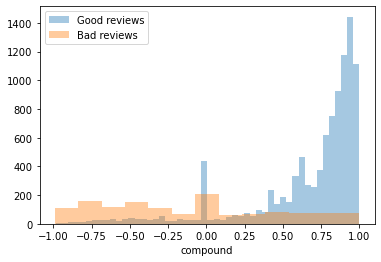

In [23]:
#plot sentiment distribution for positive and negative reviews

import seaborn as sns 

for x in [0,1]:
    subset = reviews_df[reviews_df["is_bad_review"] == x]
    
    #draw the density plot 
    if x == 0:
        label = "Good reviews"
    else: 
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist=True, kde=False, label=label)
plt.legend()

# Classification

In [24]:
#feature selection 
label = "is_bad_review"
ignore_cols = [label,"member_level", "review", "review_clean","rating"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

#split the data into train and test 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state =42)

In [25]:
# train a random forest classifier for predictions 
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

#show feature importance
a = {"feature": features, "importance": rf.feature_importances_}
helper = pd.DataFrame.from_dict(a, orient='index').transpose()
feature_importance_df = helper.sort_values("importance", ascending = False)
feature_importance_df.head(20)

,feature,importance
4,pos,0.0718779
5,compound,0.0710882
2,neg,0.0595928
3,neu,0.0293585
0,nb_chars,0.0162052
1,nb_words,0.0159708
714,word_great,0.0104593
466,word_dirty,0.00987193
146,word_bad,0.00923313
781,word_hotel,0.00875304


In [26]:
print('Test ACC: {}'.format((rf.predict(X_test) == y_test).mean()))

Test ACC: 0.8992553657468244


# Clustering

In [27]:
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
X_review = tfidf_result

In [28]:
print("Matrix shape:", X_review.shape)

Matrix shape: (11415, 1796)


/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


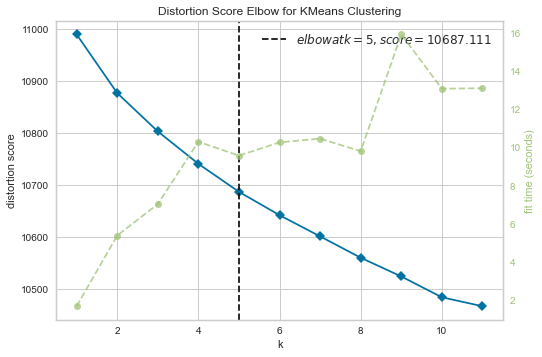

In [29]:
from sklearn.cluster import KMeans # finding the elbow for optimal clusters
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_review) 
visualizer.show()

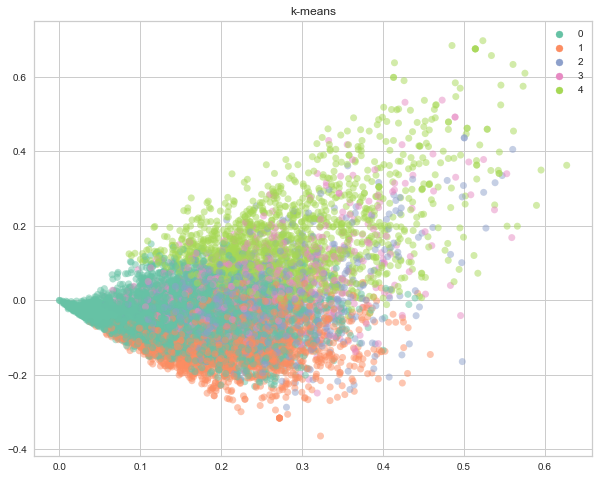

In [30]:
from sklearn.decomposition import TruncatedSVD #clustered result
kmeans = KMeans(n_clusters=5) 
y_kmeans = kmeans.fit_predict(X_review)
coordinates = TruncatedSVD().fit_transform(X_review)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=coordinates[:, 0], 
    y=coordinates[:, 1],
    hue=y_kmeans,
    alpha=.5,
    palette='Set2',
    linewidth=0
    )
plt.title('k-means')
plt.show()

# Topic Modeling and Analysis

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer( # Taken just from lecture, but the parameters are reasonable
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
    min_df = 0.001, 
    max_df = 0.5    
)

X = vectorizer.fit_transform(reviews_df['review_clean'])
print("Feature matrix shape:", X.shape)

Feature matrix shape: (11415, 1456)


In [34]:
%%time
from   sklearn.decomposition import LatentDirichletAllocation #from lec

lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 789 ms, sys: 95.6 ms, total: 885 ms
Wall time: 20 s


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

In [35]:
def print_top_words(model, feature_names, n_top_words): #from lec, but changed so instead of just printing the function returns topics
    topics = [] 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics.append(message)
    return(topics)
#     print()

In [36]:
topics = print_top_words(lda, vectorizer.get_feature_names(), n_top_words=15)

In [37]:
for i in topics: #printing the topics 
    print(i)

Topic 0: staff view hotel amaze amazing wonderful stay bar great make weekend room service beautiful welcome
Topic 1: staff stay hotel friendly helpful clean great comfortable enjoy convention room super really nice center
Topic 2: park hotel valet check charge car pay parking internet free room day cost desk make
Topic 3: recommend staff marriott great hotel highly experience stay excellent marquis property location event atlanta attend
Topic 4: make like feel stay home hotel room felt away people staff marriott leave treat sleep
Topic 5: great location hotel walk stay place staff downtown distance restaurant business close awesome room clean
Topic 6: locate easy access location hotel near conveniently mission valley convenient diego san area good marriott
Topic 7: stay atlanta marriott hotel marquis time enjoy definitely trip visit look business place marriot wonderful
Topic 8: hotel room nice great clean staff friendly food view restaurant bar comfortable center beautiful fitness
To

In [39]:
doc_topic_dist = lda.transform(X) #scores topics to docs-> prob of doc being in topic 
print(doc_topic_dist.shape)

(11415, 20)


In [45]:
%%time #code helped by Maria
for topic_index in range(0,21): #going through the range of topics 
    doc_prob_tuples = [] #creating an empty list
    for doc_index in range(len(doc_topic_dist)): #going through the length of the doc_topic_dist array
        doc_prob_tuples.append((doc_index, doc_topic_dist[doc_index, topic_index]))#make tuple of index and prob
    print('')
    print(topics[topic_index]) #print out topic
    for doc_index , prob in sorted(doc_prob_tuples, key = lambda x: x[1], reverse = True)[:10]: #showing the most highly
    #scored probabilities of doc to topic -> basically iterates over the sorted tuples (by prob) and prints the top 10
    #most highest scored doc index, review, and prob
        print('-----')
        print(doc_index,': ',reviews_df['review_clean'][doc_index], prob) 


Topic 0: staff view hotel amaze amazing wonderful stay bar great make weekend room service beautiful welcome
-----
9505 :  overall experience wonderful staff attentive need help large wed party accommodate floor go way beyond valet staff gentleman help luggage wed boxes,and altitude bar staff way go thank 0.961999999459023
-----
4604 :  plan last minute surprise husband birthday turn amazing niesha front desk)for go beyond help make stay special also thanks antwan valet service)for much patience thank 0.9441176457881348
-----
456 :  book suite hotel business meeting suite great wonderful view face east warm welcoming sunrise fantastic start day 0.9406249986708732
-----
905 :  wonderful experience one night stay especially appreciate front desk service service velocity suite lovely enjoy view 0.9366666656585176
-----
222 :  hotel big amazing view floor stand lobby look initially gigantic structure scary check morning look amazing 0.9269230753475292
-----
9344 :  staff amaze helpful fri

-----
7802 :  coronado island marriott resort spa provide perfect weekend getaway ground beautiful luxurious room food delicious close proximity san diego offer 0.9547619036452859
-----
7837 :  stay coronado island marriott wonderful hotel resort stylish clean love location beautiful island vacation relax fun 0.9441176460444761
-----
6996 :  room recently remodel quite lovely view bay downtown san diego coronado bridge 0.9269230762755906
-----
7714 :  great romantic place also perfect family fabulous view san diego water 0.9136363629457456
-----
9848 :  love location view great love balcony go back summer time balcony privacy 0.9136363606665221
-----
7721 :  great location view san diego harbor nice pool hit grandchild 0.9049999980798735
-----
7358 :  love resort beautiful facility great view downtown san diego 0.9049999942379122
-----
6763 :  beaten path coronado short ferry ride downtown san diego 0.8944444438692811
-----
6911 :  family love stay visit coronado island one favorite pl

IndexError: index 20 is out of bounds for axis 1 with size 20

In [46]:
import pandas as pd
topic_df = pd.DataFrame(data = df['rating'])

In [59]:
topic_df['topic'] = 0
topic_df['review clean'] = reviews_df['review_clean']
top = []
for doc_index in range(len(doc_topic_dist)): 
    index = doc_topic_dist[doc_index]
    top.append(np.argmax(index))
topic_df['topic'] = top
topic_df.head()

,rating,topic,review clean
0,1,12,hotel dirty
1,3,11,driveway/entrance uninspiring checkin time lon...
2,3,3,impressed continue undergo construction help
3,5,4,amaze every aspect food issue want try place g...
4,5,13,nice staff beautiful hotel view expensive vale...


In [61]:
group_top = topic_df.groupby(['topic']).mean() #grouping ratings by topics
group_top = group_top.reset_index()

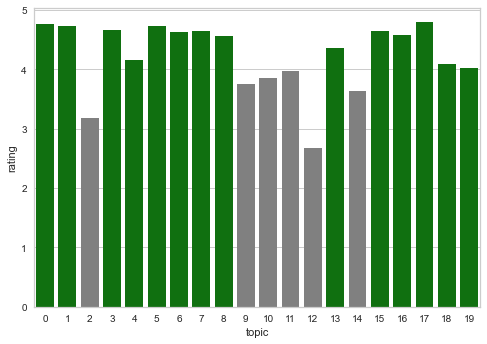

Topic 0: staff view hotel amaze amazing wonderful stay bar great make weekend room service beautiful welcome
Topic 1: staff stay hotel friendly helpful clean great comfortable enjoy convention room super really nice center
Topic 3: recommend staff marriott great hotel highly experience stay excellent marquis property location event atlanta attend
Topic 4: make like feel stay home hotel room felt away people staff marriott leave treat sleep
Topic 5: great location hotel walk stay place staff downtown distance restaurant business close awesome room clean
Topic 6: locate easy access location hotel near conveniently mission valley convenient diego san area good marriott
Topic 7: stay atlanta marriott hotel marquis time enjoy definitely trip visit look business place marriot wonderful
Topic 8: hotel room nice great clean staff friendly food view restaurant bar comfortable center beautiful fitness
Topic 13: staff hotel friendly room clean stay food good professional nice beautiful overall ac

In [70]:
#barplot per topic  
clrs = ['grey' if (x < 4) else 'green' for x in group_top['rating']]
sns.barplot(group_top['topic'], group_top['rating'], palette=clrs)
plt.show()
for i in range(len(group_top['rating'])): 
    if group_top['rating'][i] > 4:
        top_index = group_top['topic'][i]
        print(topics[top_index]) #seeing which topics have average of ratings over 4

# Emolex for Sentiment Analysis

In [111]:
def tokenize_text(text, stopwords=None): #modified code from psets
    '''
    Takes a string.
    Returns a list of tokenized sentences.
    '''
    import re
    tokenized_text = []
    text = re.split(r"\.\s*", text)
    for sent in (text):
        tokens = word_tokenize(sent.lower(), preserve_line = True )
        if stopwords != None:
            tokens = [token for token in tokens if token not in stopwords]
        tokenized_text.append(tokens)
    return tokenized_text

# Build stopword list with punctuation
stopwords = set(['and','but','am','is','are','was','were','be','being','been','the','a','an','of',
                'on','under','above','out','in','at','with','have','has','had', "'s"])
stopwords = stopwords.union(set(string.punctuation))

In [78]:
#using emolex to do sentiment analysis and look at the distribution among membership
# read and parse the emolex file
emolex_file = os.path.join('/Users/francesw/desktop/info 6350','data','emolex.txt')

def read_emolex(filepath=None): #from pset
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = emolex_file
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data
emolex = read_emolex(emolex_file)

In [105]:
# Sentiment scoring function from Pset
def sentiment_score(token_list, lexicon=None):
    '''
    Takes a tokenized sentence.
    Returns a dictionary of length-normalized EmoLex sentiment scores.
    '''
    if lexicon==None: # Get lexicon if not passed in
        lexicon = read_emolex()
    scores = defaultdict(int) # Store data for output
    token_count = 0 # Keep track of sentence length
    for token in token_list: # Iterate over tokens
        token_count += 1 # Increment token count
        for emotion in lexicon[token]: # Iterate over emotion types
            scores[emotion] += int(lexicon[token][emotion]) # Increment counts per emotion type
    if token_count > 0: # Do we have tokens?
        for emotion in scores:
            scores[emotion] /= token_count # Length normalize
    else:
        for emotion in scores:
            scores[emotion] *= 0.0
    return scores

In [129]:
rev = []
for i in reviews_df['review_clean']: 
    rev.append(i)
rev = ["".join( j for j in i if j not in string.punctuation) for i in rev]
review_text = []
for i in range(len(rev)):
    rev[i] = rev[i] +'.'
#reformatting each element-> basically all reviews are indicated with a period at the end of it--> for easier sent tokenization

In [130]:
review_text = '\n'.join(rev) #making review_text able to be run through the tokenize_text function

In [131]:
tokens = tokenize_text(review_text)

In [135]:
%%time # scoring sentiment per record 
scores = {}
for i in range(len(data['name'])-1):
    score = sentiment_score(tokens[i],lexicon=None) # Score
    scores[data['name'][i]] = score

CPU times: user 16min 58s, sys: 13.4 s, total: 17min 11s
Wall time: 17min 36s


In [136]:
#takes over 20 min 

In [137]:
display(scores)

{'Marsha': defaultdict(int,
             {'anger': 0.0,
              'anticipation': 0.0,
              'disgust': 0.5,
              'fear': 0.0,
              'joy': 0.0,
              'negative': 0.5,
              'positive': 0.0,
              'sadness': 0.0,
              'surprise': 0.0,
              'trust': 0.0}),
 'Bchatt': defaultdict(int,
             {'anger': 0.045454545454545456,
              'anticipation': 0.0,
              'disgust': 0.045454545454545456,
              'fear': 0.045454545454545456,
              'joy': 0.045454545454545456,
              'negative': 0.045454545454545456,
              'positive': 0.18181818181818182,
              'sadness': 0.045454545454545456,
              'surprise': 0.0,
              'trust': 0.045454545454545456}),
 'JenP': defaultdict(int,
             {'anger': 0.0,
              'anticipation': 0.2,
              'disgust': 0.0,
              'fear': 0.0,
              'joy': 0.0,
              'negative': 0.0,
        

In [139]:
df['anger'] = 0.0 
df['anticipation'] =0.0 
df['disgust'] =0.0 
df['fear'] =0.0 
df['joy'] =0.0 
df['negative'] =0.0 
df['positive'] =0.0 
df['sadness'] =0.0 
df['surprise'] =0.0 
df['trust'] =0.0 
#making new columns/variables per emotion per the matching names in the dictionary
sentiment_list = ['anger','anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for i in scores: 
    for x in range(len(df['name'])): 
        if i == df['name'][x]: 
            for y in sentiment_list:  
                df[y][x] = scores[i][y] 

<ipython-input-139-b28b19155b0f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y][x] = scores[i][y]


In [140]:
df.head()

,url,name,member_level,date,review,rating,is_bad_review,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,https://www.marriott.com/hotels/hotel-reviews/...,Marsha,Member,2019-10-17,This hotel is very dirty.,1,1,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
1,https://www.marriott.com/hotels/hotel-reviews/...,Bchatt,Member,2018-08-11,The driveway/entrance is uninspiring. Checkin ...,3,0,0.045455,0.000000,0.045455,0.045455,0.045455,0.045455,0.181818,0.045455,0.000000,0.045455
2,https://www.marriott.com/hotels/hotel-reviews/...,JenP,Platinum,2015-12-13,Not impressed Continue to undergo construction...,3,0,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000
3,https://www.marriott.com/hotels/hotel-reviews/...,TomSkierka,Member,2019-10-18,Amazing every aspect ... the food is an issue ...,5,0,0.000000,0.153846,0.000000,0.000000,0.230769,0.000000,0.307692,0.000000,0.230769,0.153846
4,https://www.marriott.com/hotels/hotel-reviews/...,Latasha,Member,2018-07-24,"Very nice staff, beautiful hotel and view. Ver...",5,0,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.000000,0.000000,0.000000


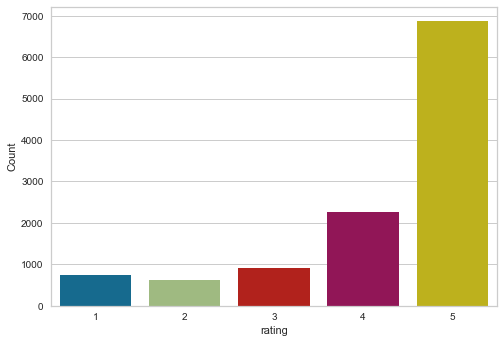

In [33]:
plt.figure()
sns.countplot(df['rating'],label="Sum")
#plotting the difference in data
plt.ylabel('Count')
plt.show()

In [149]:
r = df.groupby(['rating']).mean()
r = r.reset_index()
r.head()

,rating,is_bad_review,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,1,1,0.040449,0.049333,0.038129,0.032937,0.049851,0.083178,0.131988,0.041074,0.026385,0.066588
1,2,1,0.022355,0.056343,0.024234,0.017879,0.061493,0.061392,0.141895,0.027651,0.031038,0.070948
2,3,0,0.020686,0.056700,0.017468,0.016806,0.071538,0.052112,0.152437,0.021338,0.032067,0.079027
3,4,0,0.012114,0.071220,0.008540,0.010266,0.098355,0.033127,0.183137,0.014339,0.040735,0.105721
4,5,0,0.006511,0.060756,0.004409,0.006777,0.108331,0.020708,0.199869,0.010366,0.031861,0.106641


In [150]:
%%time #creating a list within a dictionary within a dictionary -> rating: emotion: score
scores_r = defaultdict(lambda: defaultdict(list))
for i in range(len(r['rating'])): 
    for x in sentiment_list:
        scores_r[r['rating'][i]][x] = (r[x][i])

CPU times: user 2.3 ms, sys: 433 µs, total: 2.74 ms
Wall time: 8.79 ms


In [171]:
# scores_r

In [152]:
%matplotlib inline #tweeked code from pset
def visualize_emotion_scores_r(scores):
    import pandas as pd
    import seaborn as sns
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=[1,2,3,4,5], var_name='rating').rename(columns={'index':'emotion'})
    sns.set_context('poster')
    g = sns.catplot(x='rating', y='value', col='emotion', data=df, kind='bar', col_wrap=4)
    return g

In [153]:
rating_df = pd.DataFrame.from_dict(scores_r)
print(rating_df.reset_index())

          index         1         2         3         4         5
0         anger  0.040449  0.022355  0.020686  0.012114  0.006511
1  anticipation  0.049333  0.056343  0.056700  0.071220  0.060756
2       disgust  0.038129  0.024234  0.017468  0.008540  0.004409
3          fear  0.032937  0.017879  0.016806  0.010266  0.006777
4           joy  0.049851  0.061493  0.071538  0.098355  0.108331
5      negative  0.083178  0.061392  0.052112  0.033127  0.020708
6      positive  0.131988  0.141895  0.152437  0.183137  0.199869
7       sadness  0.041074  0.027651  0.021338  0.014339  0.010366
8      surprise  0.026385  0.031038  0.032067  0.040735  0.031861
9         trust  0.066588  0.070948  0.079027  0.105721  0.106641


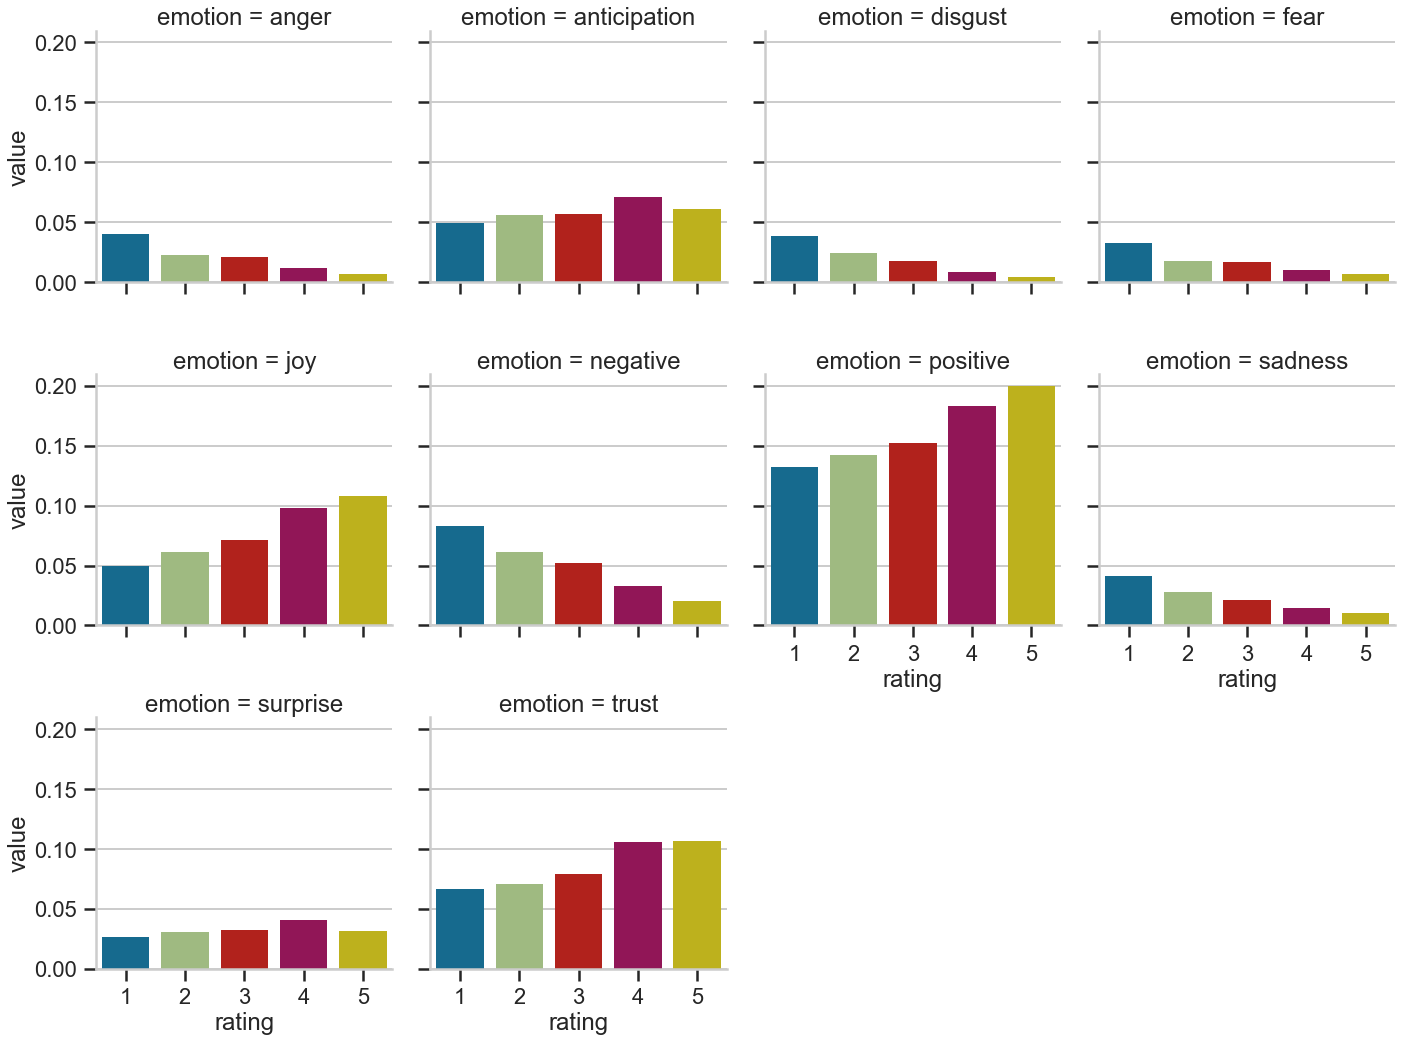

In [183]:
g= visualize_emotion_scores_r(scores_r)

# Membership Level Analysis

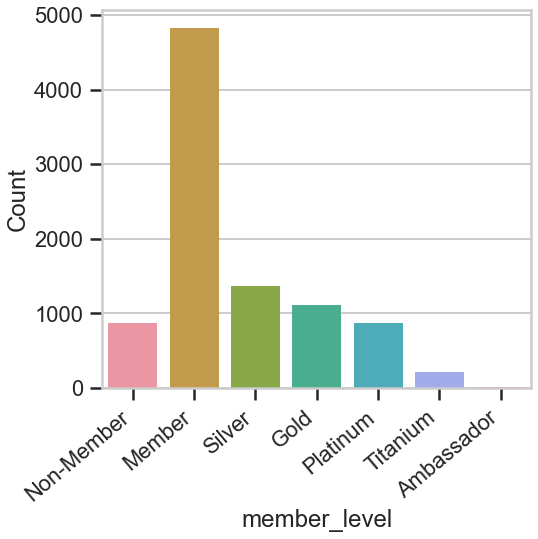

In [184]:
plt.figure(figsize=(8,8))
#plotting the difference in data- distribution
ax = sns.countplot(x=df['member_level'] ,order = ['Non-Member', 'Member', 'Silver', 'Gold', 'Platinum', 'Titanium', 'Ambassador'], data=df['member_level'])
plt.ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [185]:
mem = df.groupby(['member_level']).mean()
mem = mem.reset_index()
mem.head(7)

,member_level,rating,is_bad_review,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,Ambassador,3.777778,0.277778,0.022007,0.032837,0.021566,0.012748,0.068766,0.042666,0.178721,0.016936,0.011645,0.089049
1,Gold,4.249775,0.113616,0.009603,0.061427,0.008053,0.009978,0.098903,0.030052,0.190415,0.012254,0.032856,0.105804
2,Member,4.204272,0.120489,0.011743,0.062882,0.009802,0.010318,0.098449,0.031073,0.185104,0.014811,0.034225,0.099775
3,Non-Member,4.128028,0.141869,0.017853,0.060205,0.014907,0.017222,0.104297,0.040428,0.186257,0.020547,0.032855,0.104435
4,Platinum,4.324138,0.111494,0.010437,0.060685,0.008346,0.007336,0.095594,0.033817,0.180293,0.014603,0.031466,0.098499
5,Silver,4.250731,0.104532,0.011458,0.060794,0.008572,0.010639,0.094409,0.031980,0.181088,0.014121,0.033362,0.096344
6,Titanium,4.196262,0.154206,0.011192,0.056064,0.007576,0.012194,0.102325,0.035539,0.177648,0.013159,0.036322,0.097368


In [223]:
order = ['Non-Member', 'Member', 'Silver', 'Gold', 'Platinum', 'Titanium', 'Ambassador'] #sorting and mapping the order by member level
#Non-Member = lowest, Ambassador = highest
mapping = {r: i for i, r in enumerate(order)}
key = mem['member_level'].map(mapping)    
mem = mem.iloc[key.argsort()]
mem.head(7)

,member_level,rating,is_bad_review,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
3,Non-Member,4.128028,0.141869,0.017853,0.060205,0.014907,0.017222,0.104297,0.040428,0.186257,0.020547,0.032855,0.104435
2,Member,4.204272,0.120489,0.011743,0.062882,0.009802,0.010318,0.098449,0.031073,0.185104,0.014811,0.034225,0.099775
5,Silver,4.250731,0.104532,0.011458,0.060794,0.008572,0.010639,0.094409,0.031980,0.181088,0.014121,0.033362,0.096344
1,Gold,4.249775,0.113616,0.009603,0.061427,0.008053,0.009978,0.098903,0.030052,0.190415,0.012254,0.032856,0.105804
4,Platinum,4.324138,0.111494,0.010437,0.060685,0.008346,0.007336,0.095594,0.033817,0.180293,0.014603,0.031466,0.098499
6,Titanium,4.196262,0.154206,0.011192,0.056064,0.007576,0.012194,0.102325,0.035539,0.177648,0.013159,0.036322,0.097368
0,Ambassador,3.777778,0.277778,0.022007,0.032837,0.021566,0.012748,0.068766,0.042666,0.178721,0.016936,0.011645,0.089049


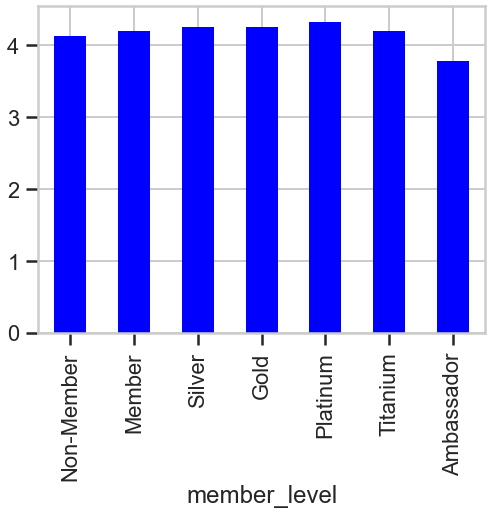

In [224]:
mem.plot(kind = 'bar', 
        x = 'member_level', 
        y = 'rating', 
        color = 'blue',
        figsize = (8,6),
        legend = False,
        sort_columns = True)
plt.show() 

In [225]:
%%time
scores_mem = defaultdict(lambda: defaultdict(list))
for i in range(len(mem['member_level'])): 
    for x in sentiment_list:
        scores_mem[mem['member_level'][i]][x] = (mem[x][i])

CPU times: user 3.46 ms, sys: 198 µs, total: 3.66 ms
Wall time: 3.75 ms


In [227]:
x = mem['member_level'].unique()

In [230]:
%matplotlib inline
def visualize_emotion_scores(scores):
    import pandas as pd
    import seaborn as sns
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=x , var_name='member_level').rename(columns={'index':'emotion'})
    sns.set_context('poster')
    g = sns.catplot(x='member_level', y='value', col='emotion', data=df, kind='bar', col_wrap=4)
    g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    return g

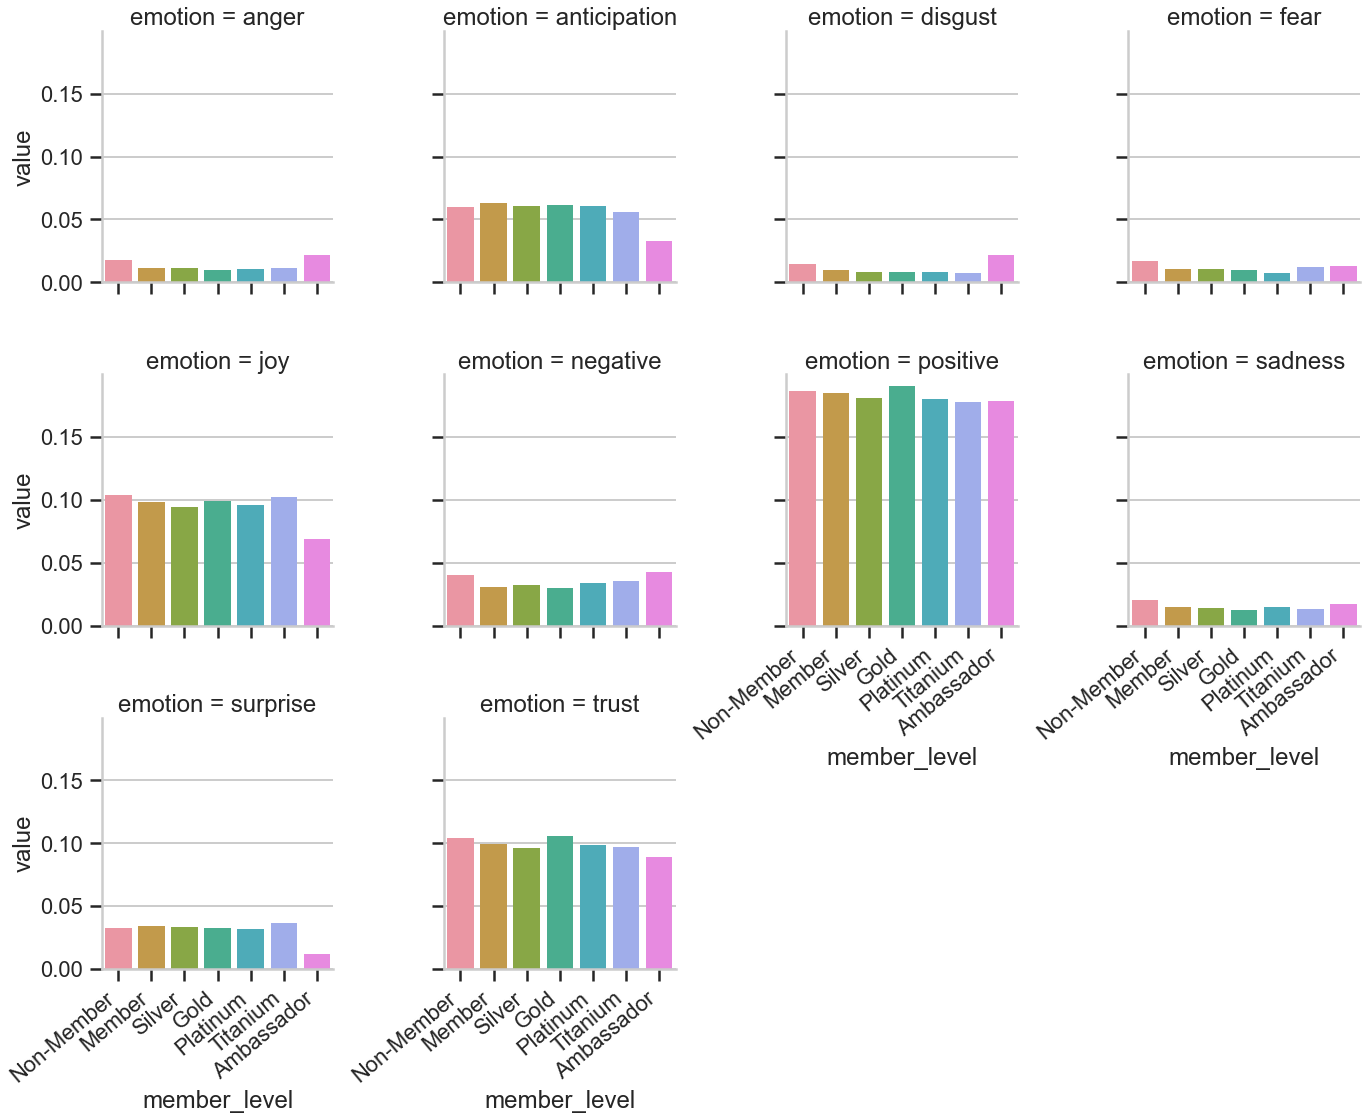

In [231]:
visualize_emotion_scores(scores_mem)